In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import sys
from torchvision import transforms
sys.path.append('D:\\rbcfrontend\\')

2.554706335067749


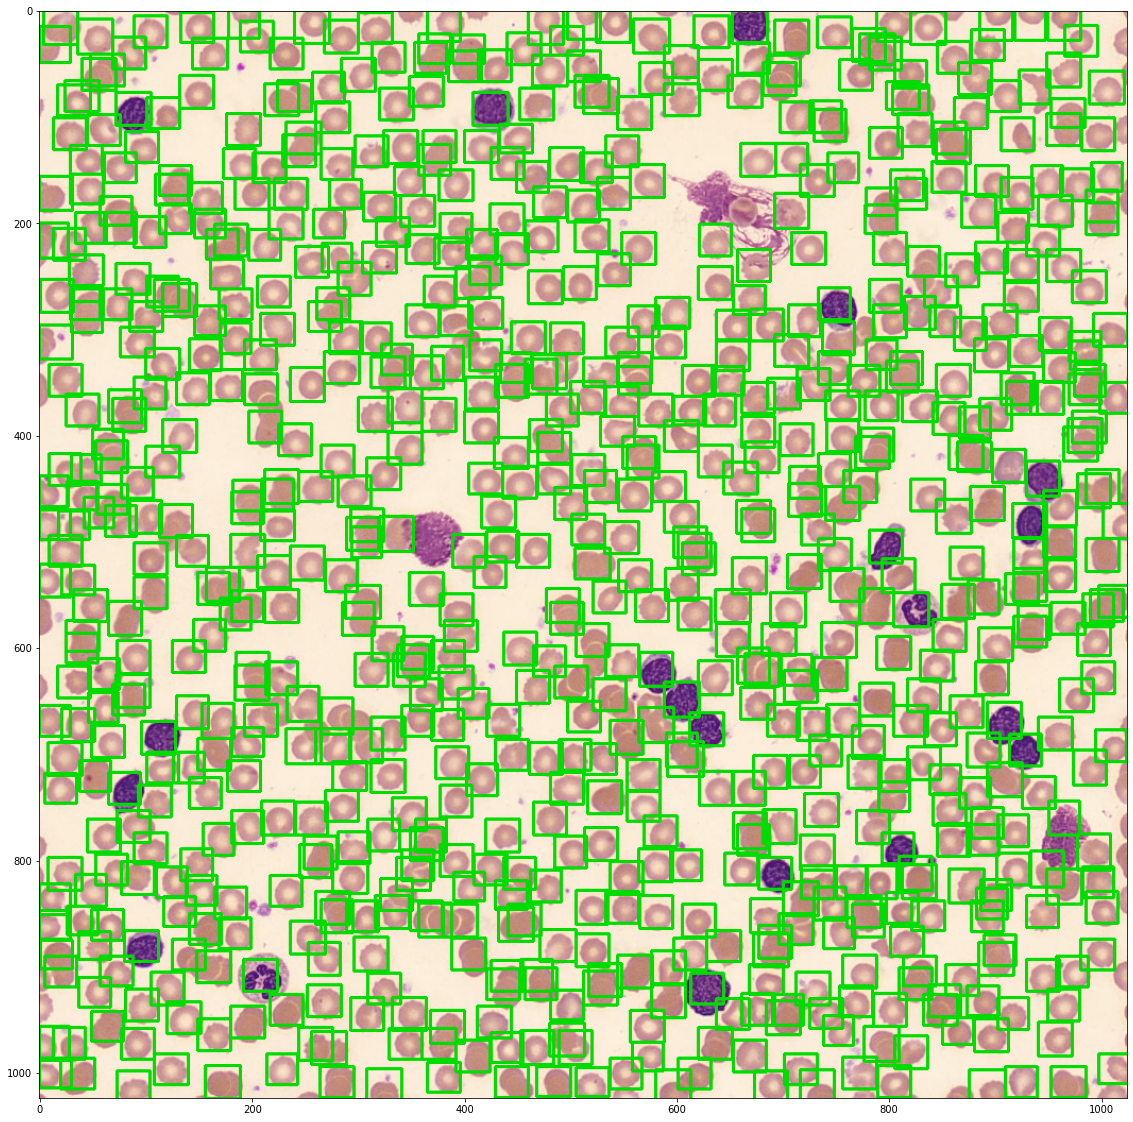

In [18]:
import centernet
import utils
import torch
import copy

image = cv2.imread('D:\\rbcfrontend\\example images\\example1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
model = centernet.build('D:\\rbcfrontend\\centernet.pt')
t0 = time.time()
hm, regr = model.pred_on_img(image)
t1 = time.time()
print(t1-t0)
sample = copy.deepcopy(image)
sample, count = utils.fullPLOT(sample, hm, regr, 0.5, 0.5)
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(sample)
plt.show()

In [13]:
def build():
  inputs = tf.keras.Input((64, 64, 3))
  x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=None)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(128, activation=None)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Dense(128, activation=None)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  x = tf.keras.Model(inputs, x)
  return x

classifier = build()
classifier.load_weights('D:\\rbcfrontend\\classifier.h5')

In [15]:
classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 128)       3584      
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 64, 64, 128)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512 

In [16]:
def residual(x, features):
  y = x
  x = tf.keras.layers.Conv2D(features, (3, 3), padding='same', strides=1, activation=None)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Concatenate()([y,x])
  return tf.keras.layers.Conv2D(features, (3, 3), padding='same', strides=2, activation=None)(x)

def build():
  inputs = tf.keras.Input((64, 64, 3))
  x = inputs
  for i in range(6):
    features = int(4*2**(i//2))
    x = residual(x, features)
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  x = tf.keras.layers.Reshape(())(x)
  x = tf.keras.Model(inputs, x)
  return x

classifier = build()
classifier.load_weights('D:\\rbcfrontend\\best.h5')

In [17]:
classifier.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 4)    112         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 64, 64, 4)    16          conv2d_14[0][0]                  
__________________________________________________________________________________________________
re_lu_12 (ReLU)                 (None, 64, 64, 4)    0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision

# Hyper-params
input_size = 1024
IN_SCALE = 1024//input_size 
MODEL_SCALE = 4

def plot(image, anns, conf):
    xs = anns['x'].to_list()
    ys = anns['y'].to_list()
    ws = anns['w'].to_list()
    hs = anns['h'].to_list()
    cs = anns['conf'].to_list()
    classes = anns['classes'].to_list()
    for x, y, w, h, c, pred in zip(xs, ys, ws, hs, cs, classes):
        if c >= conf:
            xmax = x+w
            ymax = y+h
            if pred==0:
                image = cv2.rectangle(image, (x,y), (xmax, ymax), (0, 220, 0), 2)
            else:
                image = cv2.rectangle(image, (x,y), (xmax, ymax), (220, 0, 0), 2)
    return image

def pool(data):
    stride = 3
    for y in np.arange(1,data.shape[1]-1, stride):
        for x in np.arange(1, data.shape[0]-1, stride):
            a_2d = data[x-1:x+2, y-1:y+2]
            max = np.asarray(np.unravel_index(np.argmax(a_2d), a_2d.shape))            
            for c1 in range(3):
                for c2 in range(3):
                    if not (c1== max[0] and c2 == max[1]):
                        data[x+c1-1, y+c2-1] = -1
    return data


def pred2box(hm, regr, thresh=0.99):
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    pred_r = regr[:,pred].T

    boxes = []
    scores = hm[pred]
    for i, b in enumerate(pred_r):
        arr = np.array([pred_center[1][i]*MODEL_SCALE-b[0]*input_size//2, pred_center[0][i]*MODEL_SCALE-b[1]*input_size//2, 
                      int(b[0]*input_size), int(b[1]*input_size)])
        arr = np.clip(arr, 0, input_size)
        boxes.append(arr)
    return np.asarray(boxes), scores

def toANN(bbox, scores):
    ann = pd.DataFrame()
    ann['x'] = bbox[:,0].astype(int)
    ann['y'] = bbox[:,1].astype(int)
    ann['w'] = bbox[:,2].astype(int)
    ann['h'] = bbox[:,3].astype(int)
    ann['conf'] = scores
    return ann

def fullPLOT(image, hm, regr, conf, iou, classifier, thresh):
    hm = torch.sigmoid(hm).numpy()
    hm = pool(hm)
    bbox, scores = pred2box(hm[0,0], regr[0], thresh=conf)
    if bbox.shape[0]<=1:
        return image, len(bbox)
    bbox_torch = torch.FloatTensor([[x[0], x[1], x[0]+x[2], x[1]+x[3]] for x in bbox])
    bbox_pass = torchvision.ops.nms(bbox_torch, torch.FloatTensor(scores), iou)
    bbox = bbox[bbox_pass.tolist()]
    scores = scores[bbox_pass.tolist()]
    
    allboxes = []
    for box in bbox:
        x, y, w, h = box.astype(int)
        cropped = image[y:y+h,x:x+w]
        cropped = normalize(squarepad(cropped))
        allboxes.append(cropped)

    predictions = classifier.predict(np.array(allboxes))
    classes = (predictions>=thresh).astype(int).reshape(-1)
    
    ann = toANN(bbox, scores)
    ann['classes'] = classes
    sample = plot(image, ann, 0.5)
    return sample, bbox

In [5]:
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image

normalize = Normalize()

def squarepad(image, output_size=64):
  w,h,c = image.shape
  if w>=h:
      out = np.zeros([w,w,c])
      out[:,int((w-h)/2):int((w-h)/2)+h,:] = image
  else:
      out = np.zeros([h,h,c])
      out[int((h-w)/2):int((h-w)/2)+w,:,:] = image
  return cv2.resize(out, (output_size, output_size)).astype(int)

C:\Users\konku\AppData\Local\Temp\ipykernel_20416\3892728626.py:51: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  arr = np.array([pred_center[1][i]*MODEL_SCALE-b[0]*input_size//2, pred_center[0][i]*MODEL_SCALE-b[1]*input_size//2,


3.0102832317352295


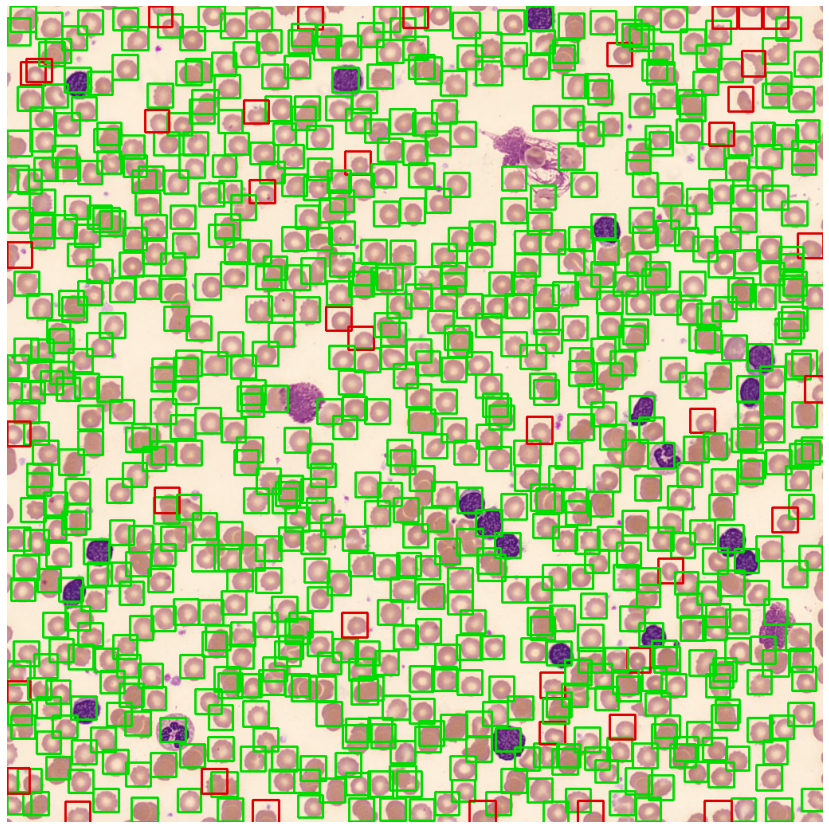

In [14]:
image = cv2.imread('D:\\rbcfrontend\\example images\\example1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
model = centernet.build('D:\\rbcfrontend\\centernet.pt')
hm, regr = model.pred_on_img(image)
sample = copy.deepcopy(image)
t0 = time.time()
sample, bbox = fullPLOT(sample, hm, regr, 0.5, 0.5, classifier, 0.5)
t1 = time.time()
print(t1-t0)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plt.imshow(sample)
plt.axis('off')
plt.show()